In [3]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pandas as pd

import seaborn as sns
sns.set()


from statsmodels.tsa.stattools import adfuller


from statsmodels.tsa.stattools import acf, pacf
from copy import deepcopy


from datetime import datetime

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [62]:
def plot_timeseries(dates , values):

    data = [go.Scatter(
              x=dates,
              y=values,
                mode='lines+markers'
             )]

    iplot(data)

In [72]:
def test_stationarity(timeseries , window = 50):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries,label='Original')
    mean = plt.plot(rolmean, color='red' , label='Moyenne Mobile')
    std = plt.plot(rolstd, label = 'Ecart Type Mobile')
    plt.legend(loc='best')
    plt.title('Ecart type et moyenne mobiles')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Résultats du test de Dickey-Fuller:')
    try:
        df_test = adfuller(timeseries.dropna(), autolag='AIC')
        df_res = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in df_test[4].items():
            df_res['Critical Value ({})'.format(key)] = value
        print(df_res) 
    except:
        print('test failed')

In [4]:
from geo_utils import filter_france_metr

df_car = pd.read_csv('data/caracteristiques.csv',dtype={'dep':'str','com':'str','code_insee':'str'})
df_car = filter_france_metr(df_car)

df_vehicules = pd.read_csv('data/vehicules.csv')
df_velos = df_vehicules[df_vehicules['catv'].isin([1,50,60,80])]
df_usagers = pd.read_csv('data/usagers.csv')
df_lieux = pd.read_csv('data/lieux.csv',low_memory=False)

In [5]:
df_accidents_velo = df_car.merge(df_velos,how='inner',on='Num_Acc')

In [6]:
df_accidents_velo.drop_duplicates(subset=['Num_Acc'], keep='last',inplace=True)

In [7]:
df_accidents_velo = filter_france_metr(df_accidents_velo)

In [10]:
df_accidents_velo_paris = df_accidents_velo[df_accidents_velo['dep']=='75']

In [22]:
df_accidents_paris = df_car[df_car['dep']=='75']

In [17]:
from date_utils import create_date_column

df_accidents_velo_paris['date'] = create_date_column(df_accidents_velo_paris)


In [23]:
df_accidents_paris['date'] = create_date_column(df_accidents_paris)

In [25]:
group_accidents_paris = df_accidents_paris.groupby('date')['Num_Acc'].nunique().reset_index()
group_accidents_paris

,date,Num_Acc
0,2005-01-01,9
1,2005-01-02,10
2,2005-01-03,9
3,2005-01-04,17
4,2005-01-05,28
...,...,...
6198,2021-12-27,8
6199,2021-12-28,8
6200,2021-12-29,6
6201,2021-12-30,5


In [19]:
group_accidents_velo_paris = df_accidents_velo_paris.groupby('date')['Num_Acc'].nunique().reset_index()
group_accidents_velo_paris

,date,Num_Acc
0,2005-01-03,2
1,2005-01-04,1
2,2005-01-05,3
3,2005-01-06,2
4,2005-01-08,1
...,...,...
5128,2021-12-27,3
5129,2021-12-28,2
5130,2021-12-29,1
5131,2021-12-30,1


In [32]:
df_stacked = group_accidents_paris.merge(group_accidents_velo_paris,how='left',on='date')

In [33]:
df_stacked['Num_Acc_y'] = df_stacked['Num_Acc_y'].fillna(0)

In [35]:
df_accidentology = df_stacked.copy()
df_accidentology['accidentology'] = df_accidentology['Num_Acc_y']/df_accidentology['Num_Acc_x']

In [8]:
df_jours_feries = pd.read_csv('data/jours_feries_metropole.csv')
df_jours_feries['date'] = pd.to_datetime(df_jours_feries['date'])

In [38]:
df_accidentology['year'] = df_accidentology['date'].dt.year

In [40]:
df_accidentology['month'] = df_accidentology['date'].dt.month

In [41]:
df_accidentology['day'] = df_accidentology['date'].dt.day

In [44]:
df_jours_feries

,date,annee,zone,nom_jour_ferie
0,2002-01-01,2002,Métropole,1er janvier
1,2002-04-01,2002,Métropole,Lundi de Pâques
2,2002-05-01,2002,Métropole,1er mai
3,2002-05-08,2002,Métropole,8 mai
4,2002-05-09,2002,Métropole,Ascension
...,...,...,...,...
281,2027-07-14,2027,Métropole,14 juillet
282,2027-08-15,2027,Métropole,Assomption
283,2027-11-01,2027,Métropole,Toussaint
284,2027-11-11,2027,Métropole,11 novembre


In [50]:
df_accidentology['is_holiday'] = 0
df_accidentology.loc[df_accidentology.date.isin(df_jours_feries.date) , 'is_holiday'] = 1

In [51]:
df_accidentology['is_holiday'].sum()

186

In [52]:
df_accidentology['weekday'] = df_accidentology.date.dt.weekday

In [54]:
df_accidentology = pd.get_dummies(df_accidentology , columns = ['weekday' , 'month'])

In [58]:
df_accidentology.shape

(6203, 27)

In [63]:
plot_timeseries(df_accidentology.date[365*3:] , df_accidentology.accidentology[365*3:] )

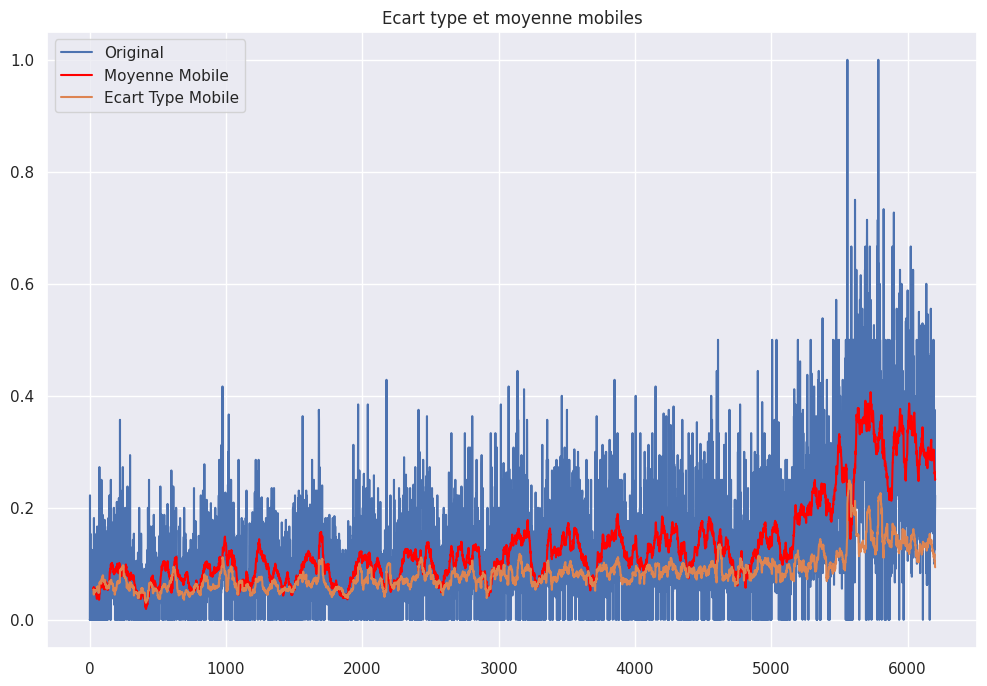

Résultats du test de Dickey-Fuller:
Test Statistic                   -2.954513
p-value                           0.039366
#Lags Used                       34.000000
Number of Observations Used    6168.000000
Critical Value (1%)              -3.431411
Critical Value (5%)              -2.862009
Critical Value (10%)             -2.567019
dtype: float64


In [73]:
test_stationarity(df_accidentology.accidentology , window = 28)

In [81]:
def plot_acf_and_pacf(timeseries , nlags = 30):
    lag_acf = acf(timeseries, nlags=nlags)
    lag_pacf = pacf(timeseries, nlags=nlags, method='ols')
    
    print('acf')
    fig = plt.figure(figsize=(20 , 10))

    sns.barplot( x=np.arange(len(lag_acf)) , y=lag_acf , palette = 'viridis')
    
    
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='red')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='red')

    plt.show();
    print('pacf')
    fig = plt.figure(figsize=(20, 10))

    sns.barplot( x=np.arange(len(lag_pacf)) , y=lag_pacf , palette = 'viridis')

    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='red')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='red')

    plt.show();

acf


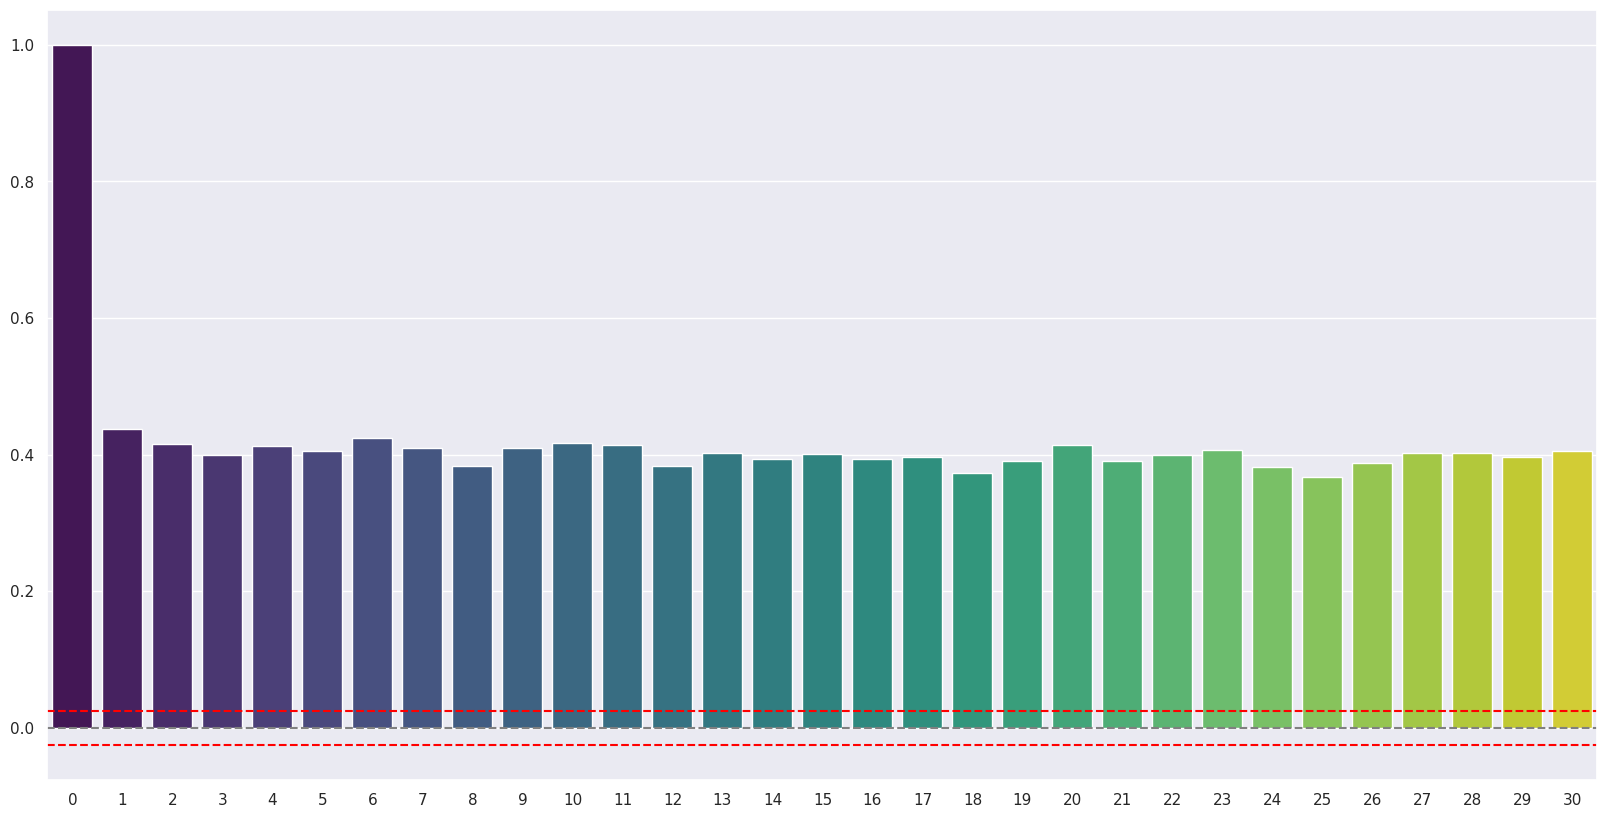

pacf


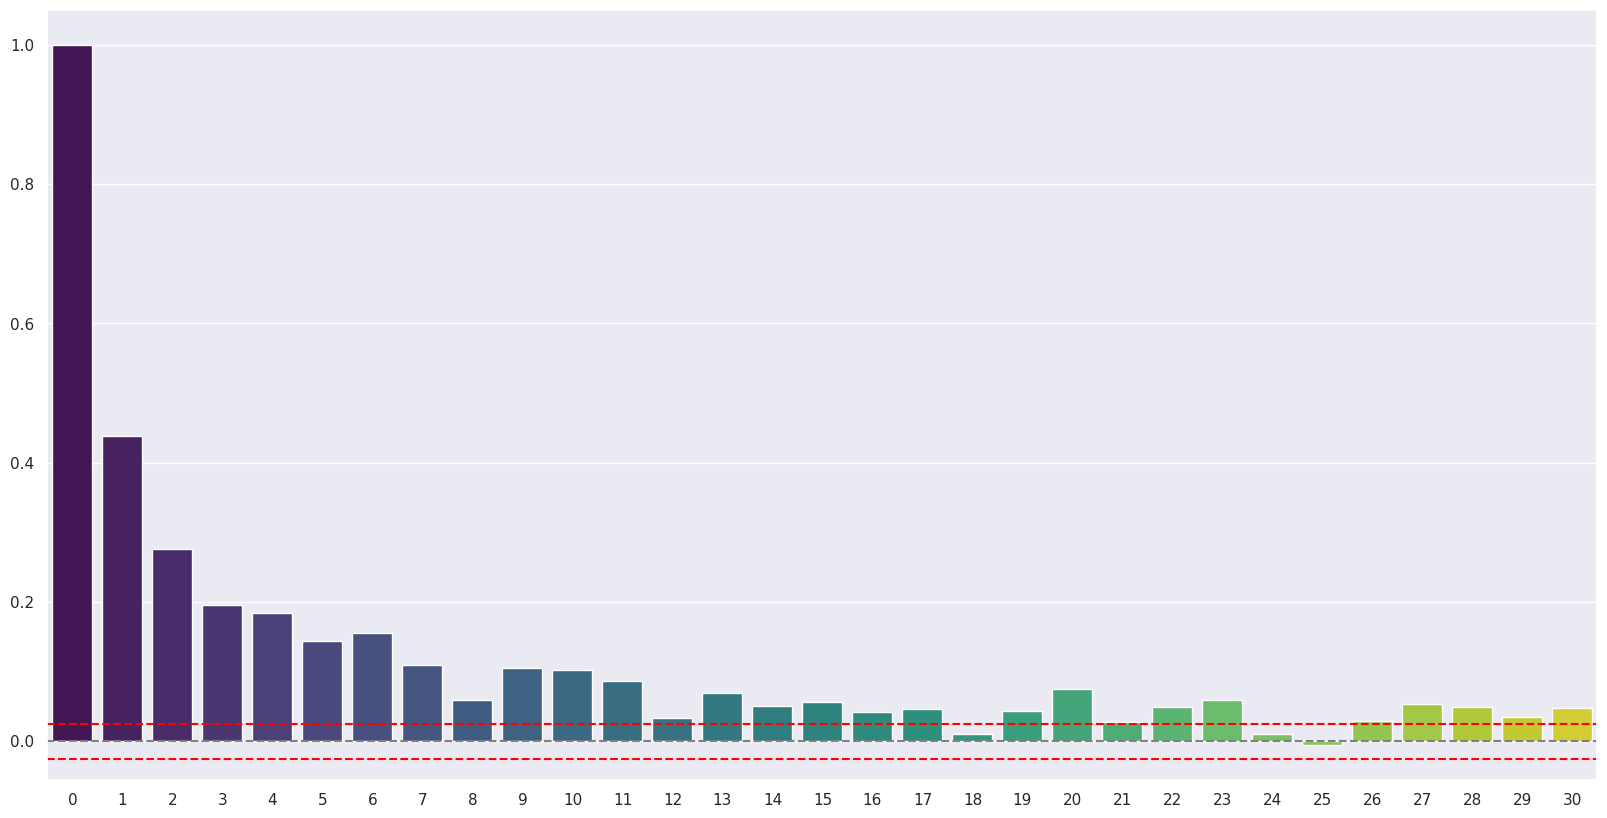

In [82]:
plot_acf_and_pacf(df_accidentology.accidentology)

<Figure size 640x480 with 0 Axes>

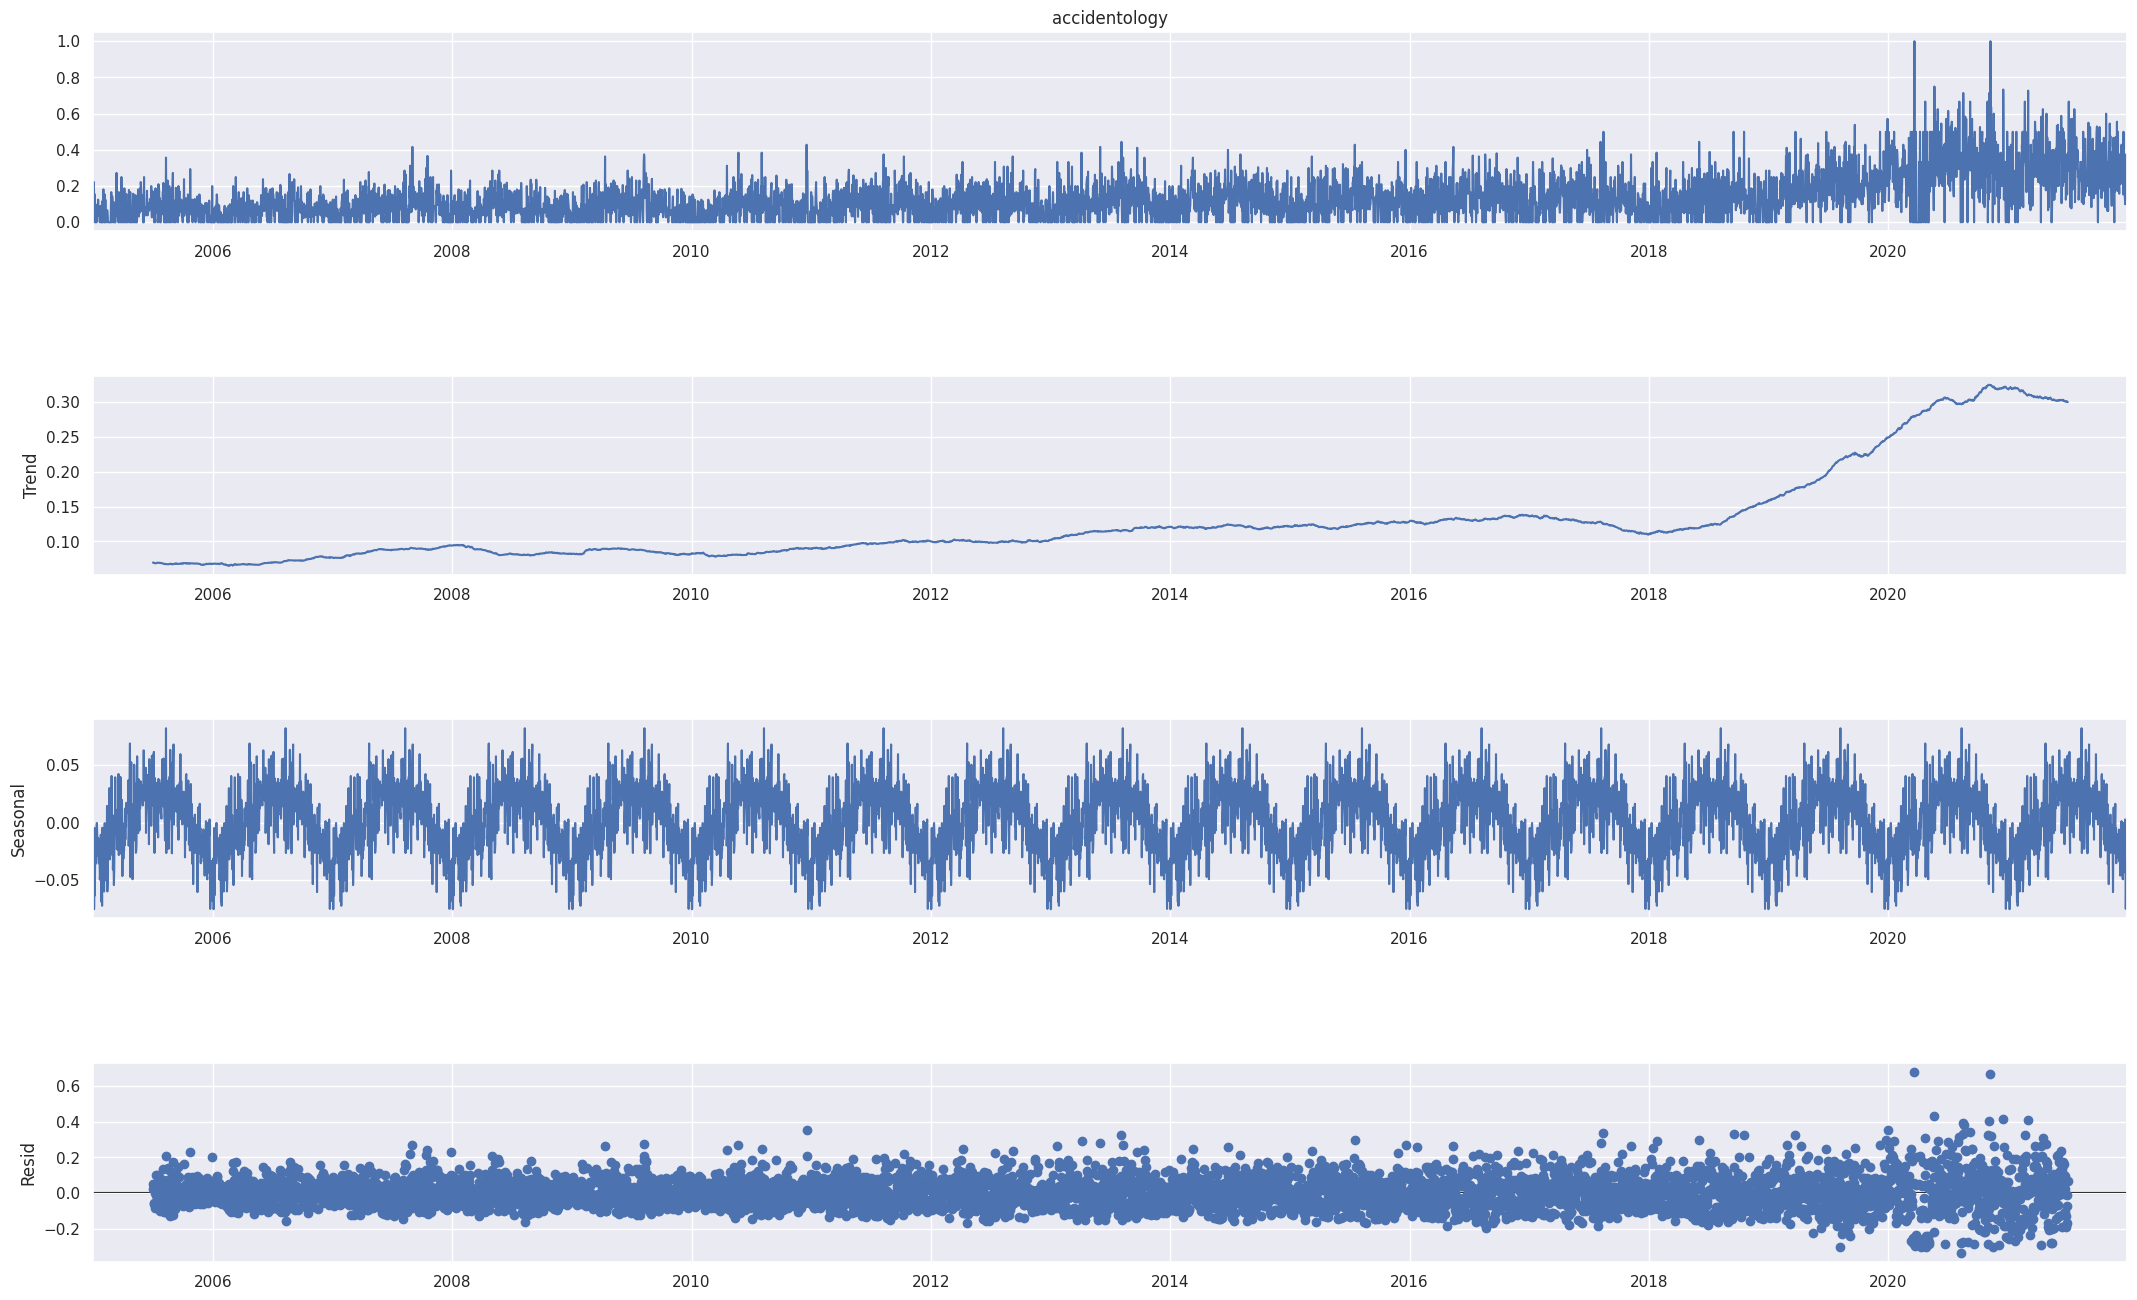

In [87]:
from statsmodels.tsa.seasonal import seasonal_decompose
df_acc = df_accidentology.set_index('date')
decomposition = seasonal_decompose(df_acc.accidentology, period=365)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(25,15)
plt.show()

In [88]:
from fbprophet import Prophet

ModuleNotFoundError: No module named 'fbprophet'